# Deep Learning Fundamental - Assignment 2 CNN models with CIFAR-10 dataset

## 1. Data Loading and preprocessing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import random

# Set random seed
random_seed = 32
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed) 
np.random.seed(random_seed)
random.seed(random_seed)

# Ensure deterministic operations with cudnn
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define data transformations with argumentation
transform = transforms.Compose([
    transforms.RandomCrop(size=(32, 32), padding=4),  # Random crop
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization
])

# Download and load CIFAR-10 training set
full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define full training data loader
full_train_loader = DataLoader(full_train_set, batch_size=64, shuffle=True, num_workers=2)

# Split dataset into training and validation sets
train_size = int(0.8 * len(full_train_set))  # 80% for training
val_size = len(full_train_set) - train_size  # 20% for validation
train_set, val_set = random_split(full_train_set, [train_size, val_size])

trainloader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

# Download and load CIFAR-10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

# Print dataset information
print(f'Train set size: {len(train_set)}')
print(f'Validation set size: {len(val_set)}')
print(f'Test set size: {len(test_set)}')

# Define CIFAR-10 class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train set size: 40000
Validation set size: 10000
Test set size: 10000


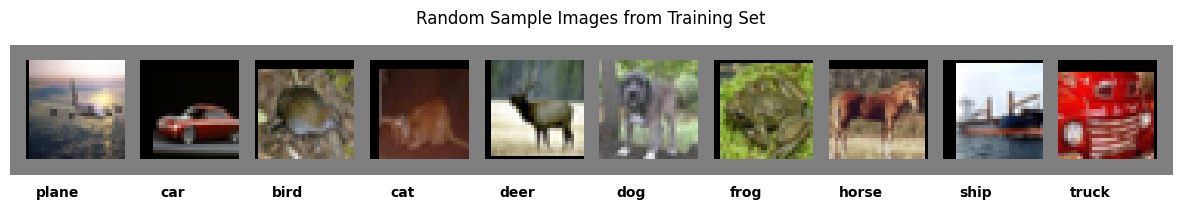

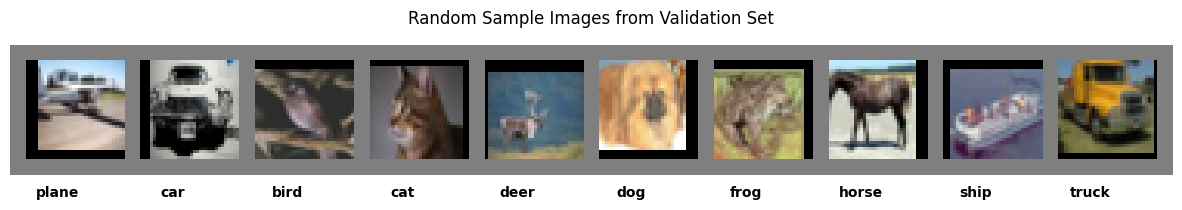

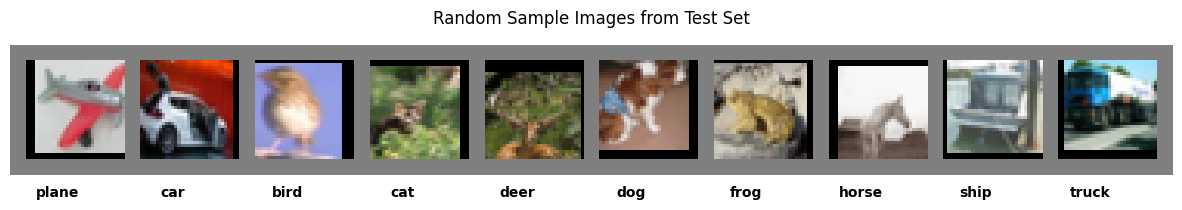

In [ ]:
# Function to display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Function to visualize one random image per class
def show_random_samples(dataset, title):
    class_indices = {i: [] for i in range(10)}  # Initialise index list for each class
    for index, (img, label) in enumerate(dataset):
        class_indices[label].append(img)

    samples = []
    labels = []
    for label in class_indices:
        if class_indices[label]:  
            sampled_img = random.choice(class_indices[label])  # Randomly select one image
            samples.append(sampled_img)
            labels.append(classes[label])  # Add the class name

    plt.figure(figsize=(15, 3)) 
    grid_img = torchvision.utils.make_grid(samples, nrow=10, padding=5)
    imshow(grid_img)

    # Label each image with the class name, positioned below each image
    for i, lbl in enumerate(labels):
        plt.text(i * 37 + 15, 45, lbl, ha='center', va='top', fontsize=10, fontweight='bold', color='black')

    plt.title(title, y=1.1)  
    plt.show()

# Visualise one random image per class from the training set
show_random_samples(train_set, 'Random Sample Images from Training Set')

# Visualise one random image per class from the validation set
show_random_samples(val_set, 'Random Sample Images from Validation Set')

# Visualise one random image per class from the test set
show_random_samples(test_set, 'Random Sample Images from Test Set')

## 2. Define a baseline model
### 2.1 Define functions

In [ ]:
# Define the training and evaluation function with Early Stopping
def train_and_evaluate(model, trainloader, valloader, criterion, optimizer, num_epochs=50, patience=10):
   
    # Store training and validation losses, training accuracy, and validation accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')  # For Early Stopping
    epochs_no_improve = 0  # Counte the number of epochs without improvement

    # Initialise learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

    for epoch in range(num_epochs):  # Set the number of training epochs
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Record training loss and accuracy
        train_losses.append(running_loss / len(trainloader))
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        # Validate the model
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)  
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Record validation loss and accuracy
        val_losses.append(val_running_loss / len(valloader))
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        # Update learning rate scheduler
        scheduler.step(val_running_loss)

        # Early Stopping check
        if val_running_loss < best_val_loss:
            best_val_loss = val_running_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Plot training and validation loss/accuracy curves
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, optimizer_name, lr):

    plt.figure(figsize=(6, 4))

    # Plot training and validation loss
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')

    # Convert accuracy to decimal
    plt.plot(np.array(train_accuracies) / 100, label='Training Accuracy', color='green')  
    plt.plot(np.array(val_accuracies) / 100, label='Validation Accuracy', color='red')  

    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'Training and Validation Loss/Accuracy\nOptimizer: {optimizer_name}, Learning Rate: {lr}')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Define the model 
def create_model(model_type):
    
    if model_type == 'ResNet18':
        model = torchvision.models.resnet18(weights=None, num_classes=10)
    elif model_type == 'SqueezeNet':
        model = torchvision.models.squeezenet1_0(weights=None, num_classes=10)
    elif model_type == 'MobileNet':
        model = torchvision.models.mobilenet_v2(weights=None, num_classes=10)
    else:
        raise ValueError('Unsupported model type')

    # Apply Xavier initialisation
    def init_weights(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    model.apply(init_weights)
    return model

### 2.2 Create a baseline model

In [ ]:
# Create and train the baseline model
def baseline_model():
    
    model_type = 'MobileNet'
    model = create_model(model_type)

    # Select the optimizer and hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.00001)  # 0.1
    criterion = nn.CrossEntropyLoss()

    print(f'Training {model_type} with optimizer: Adam, learning rate: 0.01')

    # Train and evaluate the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(
        model, trainloader, valloader, criterion, optimizer)

    # Output validation accuracy
    val_accuracy = val_accuracies[-1]
    print(f'Current Validation Accuracy: {val_accuracy:.2f}%')

    # Plot loss and accuracy curves
    plot_results(train_losses, val_losses, train_accuracies, val_accuracies, 'Adam', 0.01)

Training MobileNet with optimizer: Adam, learning rate: 0.01
Current Validation Accuracy: 74.13%


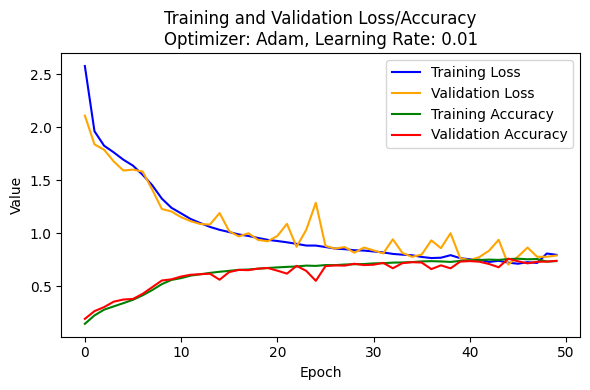

In [ ]:
# Run the baseline model
baseline_model()

## 3. Model Selection and Hyperparamenter Optimisation

### 3.1 ResNet-18 Model

In [ ]:
# Define the hyperparameter tuning function
def hyperparameter_tuning(model_type, train_data, val_data, optimizer_choices, learning_rates, weight_decay):
    best_model = None
    best_val_accuracy = 0.0
    best_optimizer_name = None
    best_learning_rate = None
    all_models = {}

    for optimizer_name in optimizer_choices:
        for lr in learning_rates:
            print(f'Training {model_type} with optimizer: {optimizer_name}, learning rate: {lr}')

            # Create a new model
            model = create_model(model_type)

            # Select the optimizer
            if optimizer_name == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            elif optimizer_name == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
            else:
                raise ValueError('Unsupported optimizer')

            # Define the loss function
            criterion = nn.CrossEntropyLoss()

            # Train and evaluate the model
            train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(
                model, train_data, val_data, criterion, optimizer)

            # Save the model and its validation accuracy
            all_models[(optimizer_name, lr)] = model
            current_val_accuracy = val_accuracies[-1]
            print(f'Current Validation Accuracy: {current_val_accuracy:.2f}%')

            # Check if this is the best model
            if current_val_accuracy > best_val_accuracy:
                best_val_accuracy = current_val_accuracy
                best_model = model  # Update the best model
                best_optimizer_name = optimizer_name  # Save the best optimizer name
                best_learning_rate = lr  # Save the best learning rate
                print("Best model updated.")

            # Plot training and validation loss/accuracy curves
            plot_results(train_losses, val_losses, train_accuracies, val_accuracies, optimizer_name, lr)

    # Output the best model and its parameters
    print(f"Best {model_type} Model Validation Accuracy:", best_val_accuracy)
    print(f"Best Optimizer: {best_optimizer_name}")
    print(f"Best Learning Rate: {best_learning_rate}")

    return best_model, best_val_accuracy

Training ResNet18 with optimizer: Adam, learning rate: 0.01
Current Validation Accuracy: 82.46%
Best model updated.


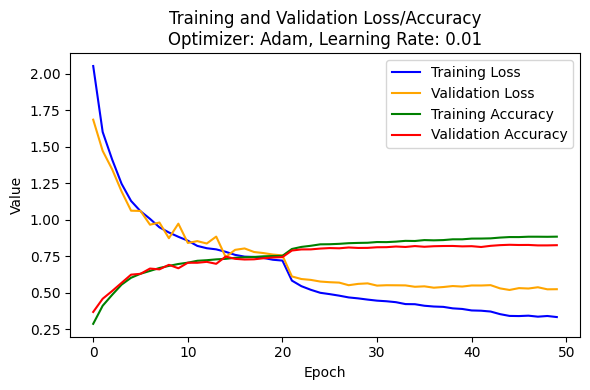

Training ResNet18 with optimizer: Adam, learning rate: 0.001
Current Validation Accuracy: 84.81%
Best model updated.


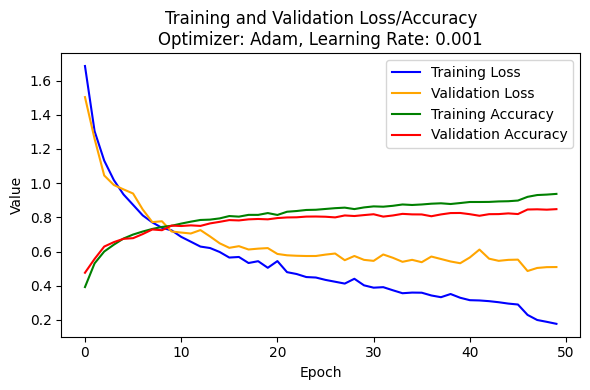

Training ResNet18 with optimizer: Adam, learning rate: 0.0001
Current Validation Accuracy: 79.61%


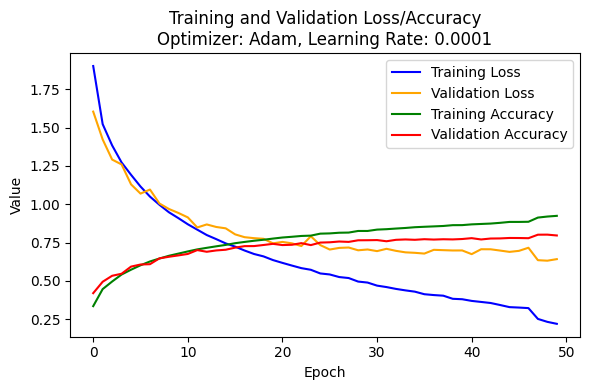

Training ResNet18 with optimizer: SGD, learning rate: 0.01
Current Validation Accuracy: 82.60%


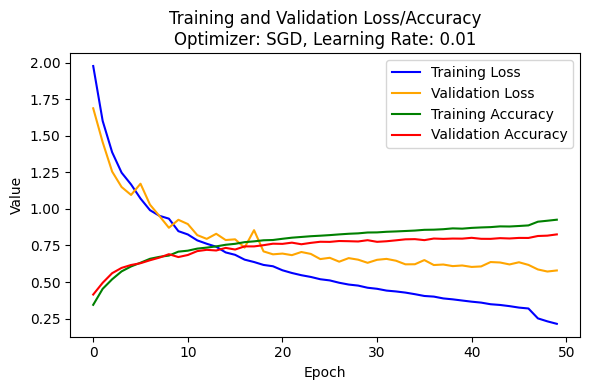

Training ResNet18 with optimizer: SGD, learning rate: 0.001
Current Validation Accuracy: 78.77%


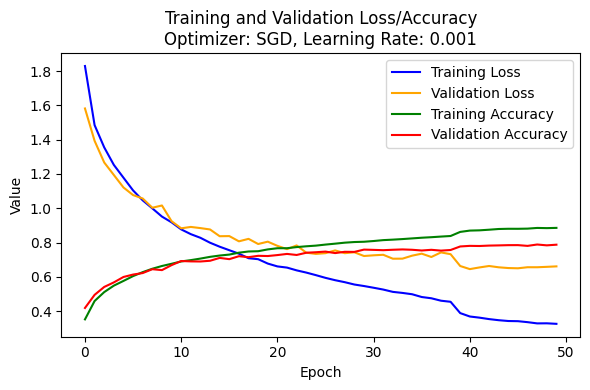

Training ResNet18 with optimizer: SGD, learning rate: 0.0001
Current Validation Accuracy: 68.82%


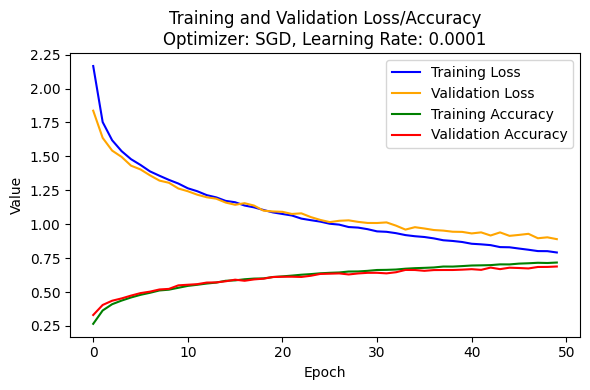

Best ResNet18 Model Validation Accuracy: 84.81
Best Optimizer: Adam
Best Learning Rate: 0.001


In [ ]:
# ResNet-18
resnet18_optimizer_choices = ['Adam', 'SGD']
resnet18_learning_rates = [0.01, 0.001, 0.0001] 
resnet18_weight_decay = 0.00001

best_resnet18_model, best_resnet18_val_accuracy = hyperparameter_tuning(
    'ResNet18', trainloader, valloader, resnet18_optimizer_choices, resnet18_learning_rates, resnet18_weight_decay
)

### 3.2 SqueezeNet Model

Training SqueezeNet with optimizer: Adam, learning rate: 0.01
Early stopping at epoch 11
Current Validation Accuracy: 9.93%
Best model updated.


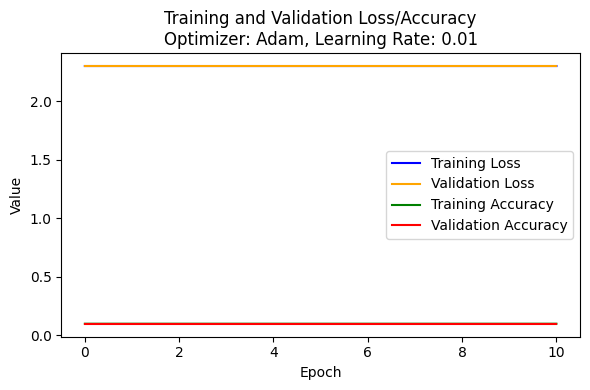

Training SqueezeNet with optimizer: Adam, learning rate: 0.001
Early stopping at epoch 11
Current Validation Accuracy: 9.93%


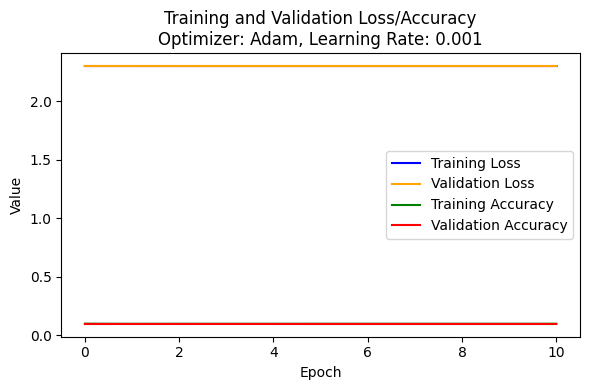

Training SqueezeNet with optimizer: Adam, learning rate: 0.0001
Current Validation Accuracy: 67.30%
Best model updated.


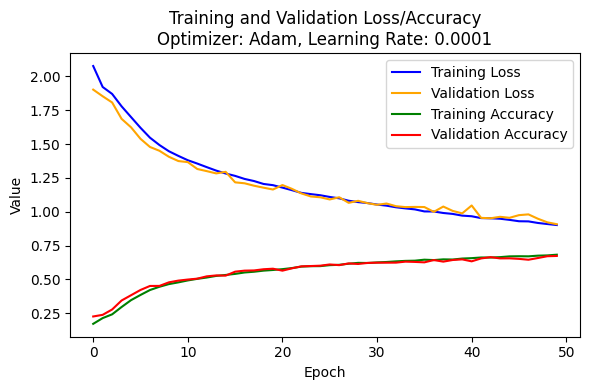

Training SqueezeNet with optimizer: SGD, learning rate: 0.01
Early stopping at epoch 11
Current Validation Accuracy: 9.93%


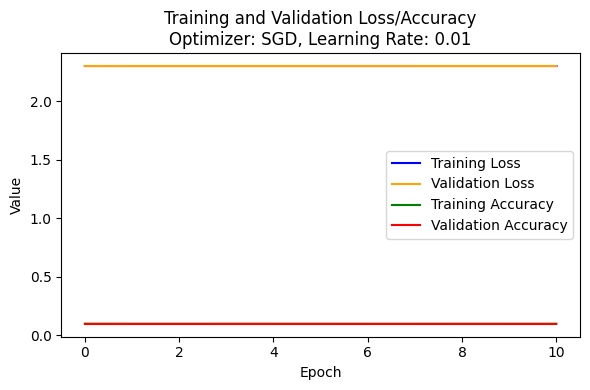

Training SqueezeNet with optimizer: SGD, learning rate: 0.001
Current Validation Accuracy: 61.90%


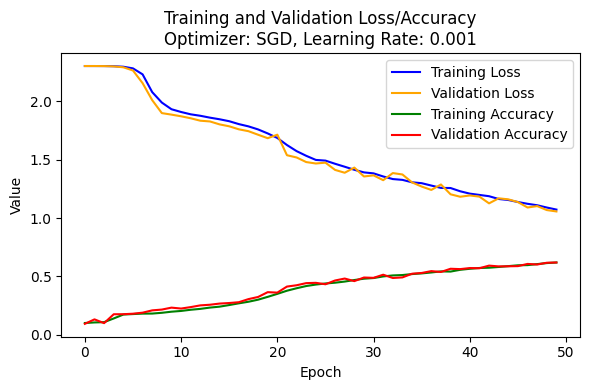

Training SqueezeNet with optimizer: SGD, learning rate: 0.0001
Early stopping at epoch 37
Current Validation Accuracy: 10.30%


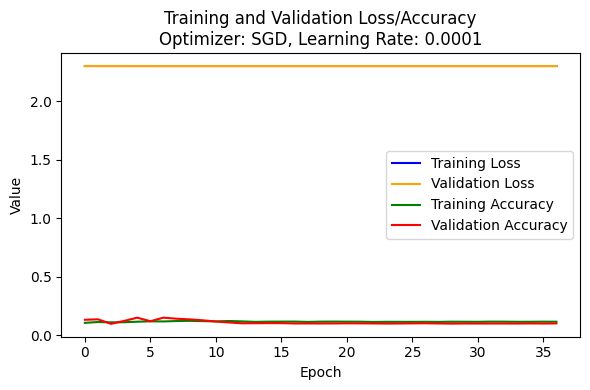

Best SqueezeNet Model Validation Accuracy: 67.3
Best Optimizer: Adam
Best Learning Rate: 0.0001


In [9]:
# SqueezeNet
squeezenet_optimizer_choices = ['Adam', 'SGD']
squeezenet_learning_rates = [0.01, 0.001, 0.0001]
squeezenet_weight_decay = 0.00001

best_squeezenet_model, best_squeezenet_val_accuracy = hyperparameter_tuning('SqueezeNet', trainloader, valloader, squeezenet_optimizer_choices, squeezenet_learning_rates, squeezenet_weight_decay)


### 3.3 MobileNet Model

Training MobileNet with optimizer: Adam, learning rate: 0.01
Current Validation Accuracy: 81.07%
Best model updated.


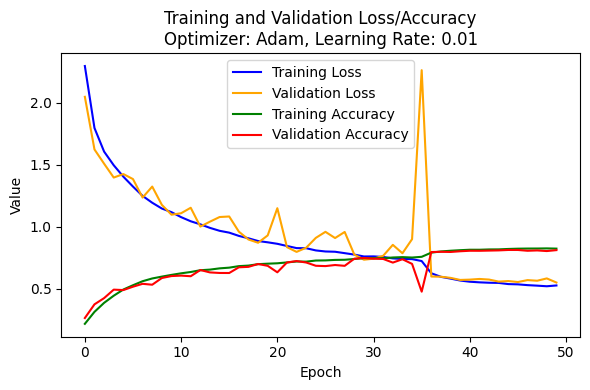

Training MobileNet with optimizer: Adam, learning rate: 0.001
Current Validation Accuracy: 65.45%


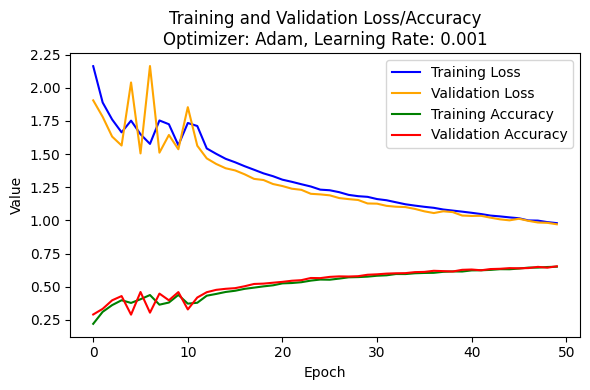

Training MobileNet with optimizer: Adam, learning rate: 0.0001
Current Validation Accuracy: 67.18%


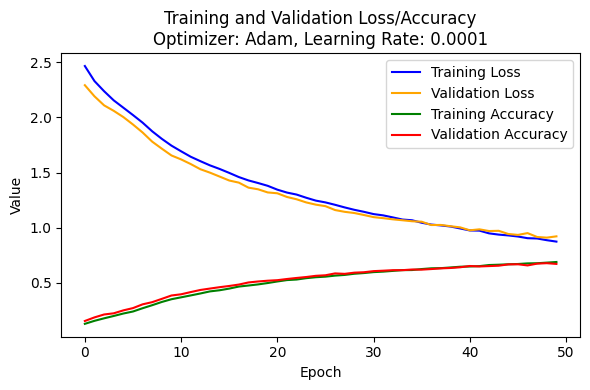

Training MobileNet with optimizer: SGD, learning rate: 0.01
Current Validation Accuracy: 63.14%


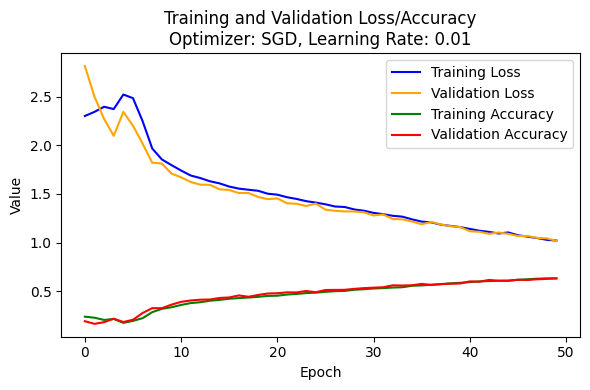

Training MobileNet with optimizer: SGD, learning rate: 0.001
Current Validation Accuracy: 69.15%


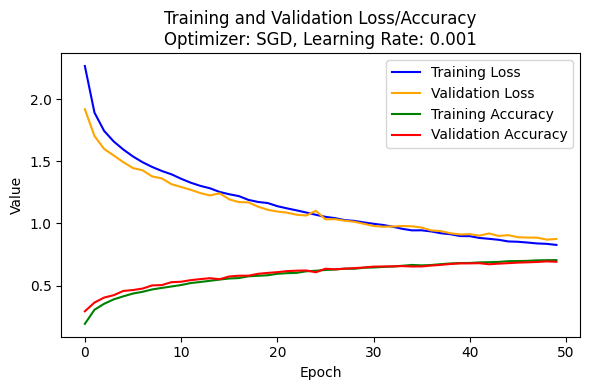

Training MobileNet with optimizer: SGD, learning rate: 0.0001
Current Validation Accuracy: 51.45%


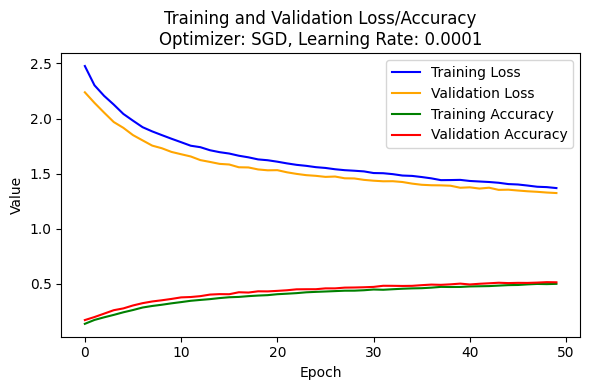

Best MobileNet Model Validation Accuracy: 81.07
Best Optimizer: Adam
Best Learning Rate: 0.01


In [ ]:
# MobileNet
mobilenet_optimizer_choices = ['Adam', 'SGD']
mobilenet_learning_rates = [0.01, 0.001, 0.0001] 
mobilenet_weight_decay = 0.00001

best_mobilenet_model, best_mobilenet_val_accuracy = hyperparameter_tuning('MobileNet', trainloader, valloader, mobilenet_optimizer_choices, mobilenet_learning_rates, mobilenet_weight_decay)


## 4. Model Comparison

In [14]:
# Compare the model performance and choose the best model
if best_resnet18_val_accuracy >= best_squeezenet_val_accuracy and best_resnet18_val_accuracy >= best_mobilenet_val_accuracy:
    best_model = best_resnet18_model
    best_val_accuracy = best_resnet18_val_accuracy
    best_model_name = "ResNet18"
elif best_squeezenet_val_accuracy >= best_resnet18_val_accuracy and best_squeezenet_val_accuracy >= best_mobilenet_val_accuracy:
    best_model = best_squeezenet_model
    best_val_accuracy = best_squeezenet_val_accuracy
    best_model_name = "SqueezeNet"
else:
    best_model = best_mobilenet_model
    best_val_accuracy = best_mobilenet_val_accuracy
    best_model_name = "MobileNet"

print(f"The best model is {best_model_name} with a validation accuracy of {best_val_accuracy:.2f}%")

The best model is ResNet18 with a validation accuracy of 84.81%


## 5. Evaluate the Best Model Performance in Test Set

In [ ]:
def retrain_and_test(model, trainloader, testloader, criterion, num_epochs=50, patience=5):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Move the model to the specified device

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate and optimizer based on the best model

    # Store training and testing losses, training accuracy and testing accuracy
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_val_loss = float('inf')  # For Early Stopping
    epochs_no_improve = 0  # Counter for the number of epochs without improvement

    # Initialize learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

    for epoch in range(num_epochs):  # Set number of training epochs
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters

            running_loss += loss.item()

            # Compute training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Record training loss and training accuracy
        train_losses.append(running_loss / len(trainloader))
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        # Perform validation
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in testloader:  # Use validation set
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)  # Compute validation loss
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Record validation loss and accuracy
        test_losses.append(val_running_loss / len(testloader))
        val_accuracy = 100 * correct / total

        # Update learning rate scheduler
        scheduler.step(val_running_loss)

        # Early Stopping check
        if val_running_loss < best_val_loss:
            best_val_loss = val_running_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break  # Stop training

    # Compute final test accuracy of the model
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    class_correct = [0] * 10  # Assume there are 10 classes
    class_total = [0] * 10

    with torch.no_grad():
        for inputs, labels in testloader:  # Use test set
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update the count of correct predictions and total samples for each class
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    # Print overall test accuracy
    test_accuracy = 100 * correct / total
    print(f'Overall Test Accuracy: {test_accuracy:.2f}%')

    # Print accuracy for each class
    for i in range(10):
        if class_total[i] > 0:
            class_accuracy = 100 * class_correct[i] / class_total[i]
            print(f'Accuracy of {classes[i]:<10}: {class_accuracy:.2f}%')  # Align output
        else:
            print(f'Accuracy of {classes[i]:<10}: No samples')  # Align output

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Retrain using the complete training set and evalute the performance of the best model on the test set
retrain_and_test(best_model, full_train_loader, testloader, criterion)

Overall Test Accuracy: 83.12%
Accuracy of plane     : 83.70%
Accuracy of car       : 89.30%
Accuracy of bird      : 84.90%
Accuracy of cat       : 64.50%
Accuracy of deer      : 81.10%
Accuracy of dog       : 76.90%
Accuracy of frog      : 89.10%
Accuracy of horse     : 84.80%
Accuracy of ship      : 89.30%
Accuracy of truck     : 87.60%
